<a href="https://colab.research.google.com/github/ellstock/Deep_Learning_Ship_Recognition/blob/master/boat_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [0]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms

## I. Uploading and preparing data

In [0]:
##Uploading data
from google.colab import files
uploaded = files.upload()

Saving shipsnet.json to shipsnet.json


In [0]:
import io
dataset_pd = pd.read_json(io.BytesIO(uploaded['shipsnet.json']))

In [37]:
%ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [38]:
## /!\ une fois que les données ont été upload une fois exécuter cette cellule:
dataset_pd = pd.read_json("shipsnet.json")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-9216a2a81e05>", line 1, in <module>
    dataset_pd = pd.read_json("shipsnet.json")
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/json/_json.py", line 592, in read_json
    result = json_reader.read()
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/json/_json.py", line 717, in read
    obj = self._get_object_parser(self.data)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/json/_json.py", line 739, in _get_object_parser
    obj = FrameParser(json, **kwargs).parse()
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/json/_json.py", line 849, in parse
    self._parse_no_numpy()
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/json/_json.py", line 1093, in _parse_no_numpy
    loads(json, precise_float=self.precise_float), dtype=Non

ValueError: ignored

In [0]:
##Reshaping each image as a 3x80x80 array
dataset_pd["images"] = dataset_pd["data"].apply(lambda x: np.array(x).reshape([80, 80, 3], order = 'F'))
dataset_pd["images"] = dataset_pd["images"].apply(lambda x: x.astype('uint8')) 

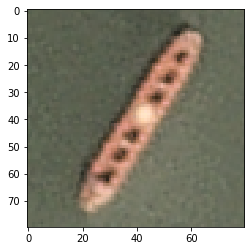

In [0]:
## Printing image with a boat
plt.imshow(dataset_pd["images"][0])

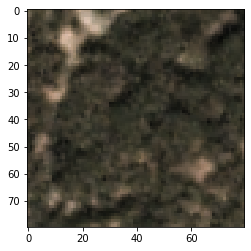

In [0]:
## Printing image without boat
plt.imshow(dataset_pd["images"][1400])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset_pd["images"], dataset_pd["labels"], test_size=0.2, random_state=42)

In [0]:
data_dir = "data"

In [0]:
%mkdir data

In [0]:
%cd data/
%mkdir train

/root/data


In [0]:
%mkdir boat
%mkdir no_boat

In [0]:
%mkdir test
%cd test/
%mkdir boat
%mkdir no_boat

/root/data/test


In [0]:
def save_arrays_as_jpg(arrays, labels, category):
  count = 0
  for array, label in zip(arrays, labels):
    imname = "_" + str(count)
    if label == 1:
      matplotlib.image.imsave(category + "/" + "boat/" + imname + ".jpg", array)
    else:
      matplotlib.image.imsave(category + "/" + "no_boat/" + imname + ".jpg", array)
    count += 1 

In [0]:
save_arrays_as_jpg(X_train, y_train, "train")

In [0]:
save_arrays_as_jpg(X_test, y_test, "test")

In [0]:
## Normalization of the images
## We compute the mean and stdev of each of the RGB channels to build a normalizer

## /!\ Pour l'instant ça ne sert à rien l'accuracy est meilleure sans normaliser

red_channel = list(dataset_pd["images"].apply(lambda x: x[:,:,0].reshape(-1)))
red_channel = [val for sublist in red_channel for val in sublist]
red_mean = np.mean(red_channel)
red_stdev = np.std(red_channel)

green_channel = list(dataset_pd["images"].apply(lambda x: x[:,:,1].reshape(-1)))
green_channel = [val for sublist in green_channel for val in sublist]
green_mean = np.mean(green_channel)
green_stdev = np.std(green_channel)

blue_channel = list(dataset_pd["images"].apply(lambda x: x[:,:,2].reshape(-1)))
blue_channel = [val for sublist in blue_channel for val in sublist]
blue_mean = np.mean(blue_channel)
blue_stdev = np.std(blue_channel)

normalize = transforms.Normalize(mean=[red_mean, green_mean, blue_mean], std=[red_stdev, green_stdev, blue_stdev])

vgg_format = transforms.Compose([
                transforms.ToTensor()])

In [0]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'test']}

In [0]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}

In [0]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)
loader_test = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=False, num_workers=6)

## II. Transfer learning VGG model


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [0]:
model_vgg = models.vgg16(pretrained=True)

In [0]:
for param in model_vgg.parameters():
    param.requires_grad = False   ## freezing the weights of all the layers so they are not modified during training
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)  ## replace the last 1000 class layer from ImageNet by a two class layer
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [0]:
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = 0.001)

In [0]:
model_vgg = model_vgg.to(device)

In [0]:
def train_model(model, dataloader, size, epochs=10, optimizer=None, criterion = nn.NLLLoss()):
    
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [0]:
%%time
train_model(model_vgg, loader_train, size=dset_sizes['train'], epochs=10,optimizer=optimizer_vgg)

Loss: 0.0020 Acc: 0.9688
Loss: 0.0020 Acc: 0.9703
Loss: 0.0018 Acc: 0.9695
Loss: 0.0017 Acc: 0.9727
Loss: 0.0015 Acc: 0.9750
Loss: 0.0014 Acc: 0.9742
Loss: 0.0013 Acc: 0.9797
Loss: 0.0013 Acc: 0.9820
Loss: 0.0013 Acc: 0.9766
Loss: 0.0013 Acc: 0.9734
CPU times: user 14.7 s, sys: 12.2 s, total: 26.8 s
Wall time: 32.3 s


In [0]:
def test_model(model,dataloader,size, criterion=nn.NLLLoss()):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [0]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_test,size=dset_sizes['test'])

Loss: 0.0110 Acc: 0.9938
